In [1]:
import json
import matplotlib.pyplot as plt

from datasets import load_dataset
import pandas as pd

from huggingface_hub import login
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer

from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, logging
import torch

In [2]:
dataset = load_dataset("csebuetnlp/xlsum", name="arabic", split="train")
print(dataset)

Dataset({
    features: ['id', 'url', 'title', 'summary', 'text'],
    num_rows: 37519
})


In [3]:
print(dataset[0])

{'id': '140323_russian_troops_crimea_naval_base', 'url': 'https://www.bbc.com/arabic/worldnews/2014/03/140323_russian_troops_crimea_naval_base', 'title': 'القوات الأوكرانية تبدأ الانسحاب من القرم', 'summary': 'بدأت القوات الأوكرانية الانسحاب من شبه جزيرة القرم.', 'text': 'وكان الرئيس الأوكراني المؤقت، الكسندر تورتشينوف، قد أمر بسحب جميع القوات الأوكرانية من القرم. وسيطرت قوات روسية صباح الاثنين على قاعدة بحرية أوكرانية في فيودوسيا، في ثالث هجوم من نوعه خلال 48 ساعة، وذلك بحسب تصريحات مسؤولين أوكرانيين لبي بي سي . وقال المتحدث باسم وزارة الدفاع الأوكرانية فلاديسلاف سيليزنيوف إن القوات الروسية هاجمت القاعدة وألقت القبض على الجنود الأوكرانيين في قاعدة فيودوسيا وقيدت أيادي ضباطهم. ومن المتوقع أن تسيطر الأزمة الأوكرانية على قمة مجموعة الدول الصناعية السبع في لاهاي. مواضيع قد تهمك نهاية وأكد الرئيس الأمريكي باراك أوباما خلال لقاء مع نظيره الصيني شى جين بينغ على أن "واشنطن وبكين يمكنهما، بالعمل سويا، تعزيز القانون الدولي واحترام سيادة الدول". وتسيطر قوات روسية حاليا على معظم القواعد العسكرية 

In [4]:
# Convert the dataset to a pandas DataFrame
df = pd.DataFrame(dataset)

# Display the dataset structure
print("Dataset Structure:")
print("------------------")
print(df.info())

# Display the first few rows of the DataFrame
num_rows_to_display = 5
print("\nFirst Few Rows of the Dataset:")
df.head()

Dataset Structure:
------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37519 entries, 0 to 37518
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       37519 non-null  object
 1   url      37519 non-null  object
 2   title    37519 non-null  object
 3   summary  37519 non-null  object
 4   text     37519 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB
None

First Few Rows of the Dataset:


,id,url,title,summary,text
0,140323_russian_troops_crimea_naval_base,https://www.bbc.com/arabic/worldnews/2014/03/1...,القوات الأوكرانية تبدأ الانسحاب من القرم,بدأت القوات الأوكرانية الانسحاب من شبه جزيرة ا...,وكان الرئيس الأوكراني المؤقت، الكسندر تورتشينو...
1,130528_egypt_nile_dam,https://www.bbc.com/arabic/middleeast/2013/05/...,هل يفرض سد النهضة الإثيوبي واقعا جديدا على مصر؟,"""هل سيتم تغيير العبارة الشهيرة للمؤرخ اليوناني...",بحلول عام 2050 ستحتاج مصر إلى 21 مليار متر مكع...
2,world-47242349,https://www.bbc.com/arabic/world-47242349,تعرف على منطقة كشمير التي تسببت بحربين بين اله...,قالت الشرطة في القطاع الهندي من إقليم كشمير إن...,وذكرت وكالة الأنباء المحلية (جي.إن.إس) أن جماع...
3,vert-cul-55078328,https://www.bbc.com/arabic/vert-cul-55078328,ماذا تعرف عن العالم الخفي للمعابد اليابانية ال...,في عام 816، تجول راهب يدعى كوكاي، في المنحدرات...,ووقع اختياره على واد عمقه 800 متر محاط بثماني ...
4,141023_yemen_hodeida,https://www.bbc.com/arabic/middleeast/2014/10/...,"اشتباك بين الحوثيين و""الحراك التهامي"" في الحدي...","أكد مصدر في ""الحراك التهامي"" لأبناء محافظة الح...",مسلح حوثي في إب وقال المصدر إن المسلحين الحوثي...


In [5]:
# Remove other columns
dataset = dataset.remove_columns(["id","url","title"])
dataset

Dataset({
    features: ['summary', 'text'],
    num_rows: 37519
})

In [6]:
# Split dataset to train and test
dataset_split = dataset.train_test_split(test_size=0.3)
train_data_txt = dataset_split["train"]
validation_data_txt = dataset_split["test"]

In [7]:
# Load LLaMA model
logging.set_verbosity_error()

model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

# Check if tokenizer already has a pad_token
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

In [8]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

In [9]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)

model.config.pad_token_id = tokenizer.pad_token_id

In [10]:
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id
model.gradient_checkpointing_enable()

model = prepare_model_for_kbit_training(model)

In [11]:
# LoRA Configuration
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "v_proj"]
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 1,126,400 || all params: 1,101,174,784 || trainable%: 0.1023


In [12]:
max_length = 512

def preprocess_function(examples):
    input_ids_list = []
    attention_masks = []
    labels_list = []

    for text, summary in zip(examples["text"], examples["summary"]):
        # Full input (prompt + target)
        prompt = f"Summarize this article:\n\n{text}\n\nSummary:"
        full_text = prompt + " " + summary

        # Tokenize full input
        tokenized = tokenizer(
            full_text,
            max_length=max_length,
            truncation=True,
            padding="max_length"
        )

        input_ids = tokenized["input_ids"]
        attention_mask = tokenized["attention_mask"]

        # Mask out prompt tokens in labels
        labels = input_ids.copy()
        prompt_ids = tokenizer(prompt, truncation=True, max_length=max_length)["input_ids"]
        prompt_len = len(prompt_ids)

        labels[:prompt_len] = [-100] * prompt_len

        input_ids_list.append(input_ids)
        attention_masks.append(attention_mask)
        labels_list.append(labels)

    return {
        "input_ids": input_ids_list,
        "attention_mask": attention_masks,
        "labels": labels_list,
    }

In [13]:
training_args = TrainingArguments(
    output_dir="./tinyllama-xlsum-arabic2",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    logging_dir="./logs",
    logging_steps=50,
    eval_steps=200,
    save_steps=500,
    save_total_limit=2,
    fp16=True,
    gradient_accumulation_steps=2,
    warmup_steps=100,
    weight_decay=0.01,
    report_to="none"
)

In [14]:
tokenized_train = train_data_txt.map(preprocess_function, batched=True, remove_columns=train_data_txt.column_names)
tokenized_val = validation_data_txt.map(preprocess_function, batched=True, remove_columns=validation_data_txt.column_names)

Map:   0%|          | 0/26263 [00:00<?, ? examples/s]

Map:   0%|          | 0/11256 [00:00<?, ? examples/s]

In [15]:
trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
)

trainer.train()

Truncating train dataset:   0%|          | 0/26263 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/11256 [00:00<?, ? examples/s]

{'loss': 1.6606, 'grad_norm': 0.42898812890052795, 'learning_rate': 2.4e-05, 'num_tokens': 204800.0, 'mean_token_accuracy': 0.5390117421746254, 'epoch': 0.015229972586049346}
{'loss': 1.6166, 'grad_norm': 0.5782985687255859, 'learning_rate': 4.9e-05, 'num_tokens': 409600.0, 'mean_token_accuracy': 0.5441585138440133, 'epoch': 0.03045994517209869}
{'loss': 1.5419, 'grad_norm': 0.7376047372817993, 'learning_rate': 4.985289610787619e-05, 'num_tokens': 614400.0, 'mean_token_accuracy': 0.555733854174614, 'epoch': 0.045689917758148034}
{'loss': 1.4933, 'grad_norm': 0.8008075952529907, 'learning_rate': 4.9699662886913885e-05, 'num_tokens': 819200.0, 'mean_token_accuracy': 0.5646281802654266, 'epoch': 0.06091989034419738}
{'loss': 1.4765, 'grad_norm': 0.8264291882514954, 'learning_rate': 4.9546429665951584e-05, 'num_tokens': 1024000.0, 'mean_token_accuracy': 0.5683512723445893, 'epoch': 0.07614986293024673}
{'loss': 1.4629, 'grad_norm': 0.9239597320556641, 'learning_rate': 4.9393196444989276e-0

TrainOutput(global_step=16415, training_loss=1.3349352821212987, metrics={'train_runtime': 71192.5627, 'train_samples_per_second': 1.845, 'train_steps_per_second': 0.231, 'total_flos': 4.177763540611891e+17, 'train_loss': 1.3349352821212987})

In [19]:
trainer.save_model()

In [28]:
# Save model and tokenizer
model.save_pretrained("./tinyllama-lora-xlsum2")
tokenizer.save_pretrained("./tinyllama-lora-xlsum2")

('./tinyllama-lora-xlsum2\\tokenizer_config.json',
 './tinyllama-lora-xlsum2\\special_tokens_map.json',
 './tinyllama-lora-xlsum2\\tokenizer.model',
 './tinyllama-lora-xlsum2\\added_tokens.json',
 './tinyllama-lora-xlsum2\\tokenizer.json')

In [20]:
model = AutoModelForCausalLM.from_pretrained("./tinyllama-xlsum-arabic2")
tokenizer = AutoTokenizer.from_pretrained("./tinyllama-xlsum-arabic2")

In [22]:
model = AutoModelForCausalLM.from_pretrained("./tinyllama-xlsum-arabic2").to("cpu")

In [23]:
# Load trainer state logs
with open("./tinyllama-xlsum-arabic2/checkpoint-16415/trainer_state.json", "r") as f:
    trainer_state = json.load(f)

In [25]:
# Get training log history
log_history = trainer.state.log_history

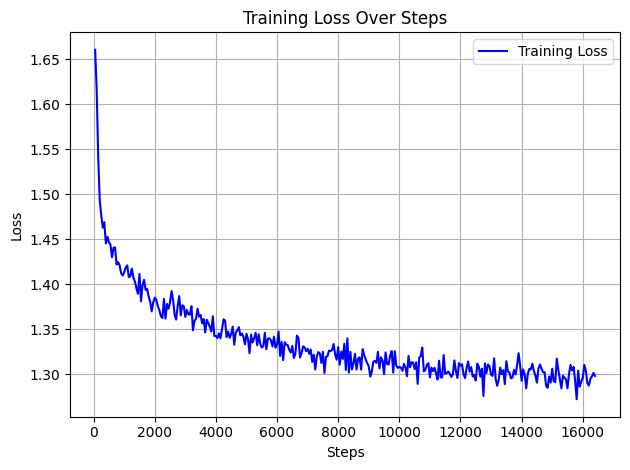

In [26]:
train_steps = [entry["step"] for entry in log_history if "loss" in entry]
train_losses = [entry["loss"] for entry in log_history if "loss" in entry]

plt.plot(train_steps, train_losses, label="Training Loss", color='blue')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

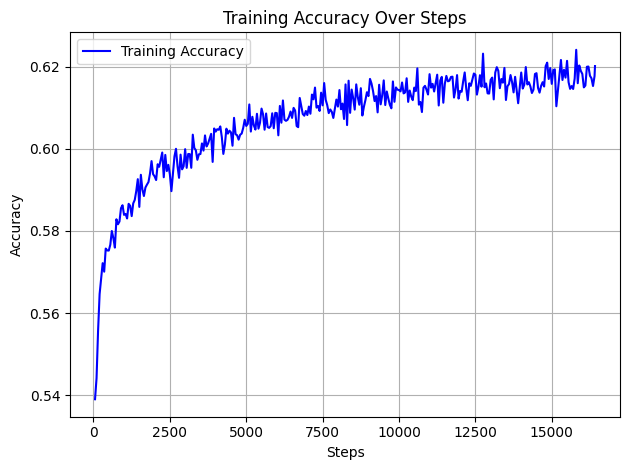

In [27]:
train_steps = [entry["step"] for entry in log_history if "mean_token_accuracy" in entry]
train_accuracy = [entry["mean_token_accuracy"] for entry in log_history if "mean_token_accuracy" in entry]

plt.plot(train_steps, train_accuracy, label="Training Accuracy", color='blue')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Steps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
# Grenerate summary
def generate_summary(text):
    prompt = f"Summarize this article:\n\n{text}\n\nSummary:"
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048)
    summary_ids = model.generate(
        **inputs,
        max_new_tokens=128,   
        num_beams=4,
        early_stopping=True
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

In [41]:
# Example
sample_text = "التكنولوجيا الحديثة أصبحت جزءًا لا يتجزأ من حياتنا اليومية ..."
print(generate_summary(sample_text))

Summarize this article:

التكنولوجيا الحديثة أصبحت جزءًا لا يتجزأ من حياتنا اليومية ...

Summary: أعلنت منظمة التكنولوجيا الحديثة أنها تعتقد أنها تعمل في مجال التكنولوجيا الحديثة والتكنولوجيا الحديثة أصبحت جزءًا لا يتجزأ من حياتنا اليومية.


In [42]:
# Example
sample_text = """شهدت السنوات الأخيرة تطورًا هائلًا في مجال التكنولوجيا، حيث أصبحت الأجهزة الذكية مثل الهواتف المحمولة والحواسيب اللوحية جزءًا لا يتجزأ من حياتنا اليومية. لم يعد استخدام الإنترنت مقتصرًا على الترفيه أو التواصل الاجتماعي فحسب، بل أصبح وسيلة رئيسية للعمل والتعليم والتجارة. ساهمت تطبيقات الذكاء الاصطناعي وتعلم الآلة في تحسين الخدمات الصحية من خلال تحليل البيانات الطبية والتشخيص المبكر للأمراض.
وعلى الصعيد الاقتصادي، أدت التكنولوجيا إلى نشوء مجالات عمل جديدة مثل التسويق الرقمي، وتطوير التطبيقات، والعمل عن بُعد، مما أتاح فرصًا وظيفية واسعة للأفراد حول العالم. كما ساهمت تقنيات الواقع الافتراضي والواقع المعزز في تحويل طريقة تفاعلنا مع البيئة الرقمية.
في المقابل، أثارت هذه التغيرات السريعة تحديات عدة تتعلق بالخصوصية الرقمية وأمن المعلومات، إذ أصبحت الهجمات السيبرانية أكثر تعقيدًا وخطورة. لذلك، بات من الضروري تعزيز الوعي المجتمعي بأهمية حماية البيانات الشخصية، وتحديث السياسات والقوانين التي تنظم استخدام التكنولوجيا.
وفي الختام، لا شك أن التكنولوجيا الحديثة قدمت فوائد عظيمة للبشرية، لكن الاستفادة منها تتطلب توازنًا بين التطور التقني والحفاظ على القيم الإنسانية."""
print(generate_summary(sample_text))

Summarize this article:

شهدت السنوات الأخيرة تطورًا هائلًا في مجال التكنولوجيا، حيث أصبحت الأجهزة الذكية مثل الهواتف المحمولة والحواسيب اللوحية جزءًا لا يتجزأ من حياتنا اليومية. لم يعد استخدام الإنترنت مقتصرًا على الترفيه أو التواصل الاجتماعي فحسب، بل أصبح وسيلة رئيسية للعمل والتعليم والتجارة. ساهمت تطبيقات الذكاء الاصطناعي وتعلم الآلة في تحسين الخدمات الصحية من خلال تحليل البيانات الطبية والتشخيص المبكر للأمراض.
وعلى الصعيد الاقتصادي، أدت التكنولوجيا إلى نشوء مجالات عمل جديدة مثل التسويق الرقمي، وتطوير التطبيقات، والعمل عن بُعد، مما أتاح فرصًا وظيفية واسعة للأفراد حول العالم. كما ساهمت تقنيات الواقع الافتراضي والواقع المعزز في تحويل طريقة تفاعلنا مع البيئة الرقمية.
في المقابل، أثارت هذه التغيرات السريعة تحديات عدة تتعلق بالخصوصية الرقمية وأمن المعلومات، إذ أصبحت الهجمات السيبرانية أكثر تعقيدًا وخطورة. لذلك، بات من الضروري تعزيز الوعي المجتمعي بأهمية حماية البيانات الشخصية، وتحديث السياسات والقوانين التي تنظم استخدام التكنولوجيا.
وفي الختام، لا شك أن التكنولوجيا الحديثة قدمت فوائد عظي

In [43]:
# Example
sample_text = """شهد العالم خلال العقود الأخيرة تحولًا جذريًا في طريقة عيش الأفراد وعملهم وتواصلهم، بفضل التقدم السريع في مجال التكنولوجيا الرقمية. فقد أصبحت الأجهزة الذكية والتقنيات المتطورة مثل الإنترنت عالي السرعة، والذكاء الاصطناعي، والحوسبة السحابية، جزءًا لا يتجزأ من الحياة اليومية لملايين البشر حول العالم.
في مجال التعليم، ساهمت التكنولوجيا في إحداث نقلة نوعية، حيث ظهرت منصات التعلم عن بُعد التي مكّنت الطلاب من متابعة دراستهم من أي مكان في العالم. كما أصبح من الممكن تقديم محاضرات افتراضية، وتصميم مناهج تفاعلية تعتمد على الفيديوهات والمحاكاة والألعاب التعليمية، مما عزز من فاعلية العملية التعليمية وقلل الفجوة بين المتعلمين.
أما في قطاع الصحة، فقد مكّن الذكاء الاصطناعي الأطباء من تشخيص الأمراض بدقة وسرعة من خلال تحليل الصور الطبية والبيانات السريرية. وأصبحت الروبوتات تُستخدم في بعض العمليات الجراحية الدقيقة، بينما ساعدت تطبيقات الهواتف في متابعة الحالة الصحية للمرضى وتنبيههم بشأن الأدوية أو مواعيد الفحوصات.
من الناحية الاقتصادية، أدت هذه الثورة الرقمية إلى خلق فرص جديدة للأعمال، مثل التجارة الإلكترونية وتطوير التطبيقات والعمل الحر عبر الإنترنت. وساعدت الحوسبة السحابية الشركات على تخزين البيانات وتشغيل الأنظمة عن بُعد، مما قلل من التكاليف التشغيلية وسهّل التوسع في الأسواق العالمية.
في المقابل، أثار هذا التطور السريع مخاوف متزايدة بشأن أمن المعلومات والخصوصية الرقمية. إذ أصبحت الهجمات السيبرانية أكثر تعقيدًا وتهديدًا للبنى التحتية الحيوية، مما استدعى تعزيز وسائل الحماية وتحديث التشريعات القانونية المرتبطة بالفضاء الرقمي. كما زادت الحاجة إلى توعية الأفراد حول كيفية حماية بياناتهم الشخصية وتفادي التهديدات الإلكترونية.
ولا يمكن إغفال التأثير الاجتماعي لهذا التحول، حيث تغيرت طبيعة العلاقات الاجتماعية وأصبح التواصل يعتمد بشكل كبير على الوسائط الرقمية، مما أثار نقاشات حول تأثير التكنولوجيا على العلاقات الإنسانية والتفاعل الواقعي.
وفي الختام، فإن التكنولوجيا الحديثة رغم ما تقدمه من فوائد كبيرة، تفرض تحديات معقدة تتطلب وعيًا مجتمعيًا وتعاونًا دوليًا لضمان استخدامها بما يخدم الإنسان ويحافظ على القيم الأساسية للمجتمعات."""
print(generate_summary(sample_text))

Summarize this article:

شهد العالم خلال العقود الأخيرة تحولًا جذريًا في طريقة عيش الأفراد وعملهم وتواصلهم، بفضل التقدم السريع في مجال التكنولوجيا الرقمية. فقد أصبحت الأجهزة الذكية والتقنيات المتطورة مثل الإنترنت عالي السرعة، والذكاء الاصطناعي، والحوسبة السحابية، جزءًا لا يتجزأ من الحياة اليومية لملايين البشر حول العالم.
في مجال التعليم، ساهمت التكنولوجيا في إحداث نقلة نوعية، حيث ظهرت منصات التعلم عن بُعد التي مكّنت الطلاب من متابعة دراستهم من أي مكان في العالم. كما أصبح من الممكن تقديم محاضرات افتراضية، وتصميم مناهج تفاعلية تعتمد على الفيديوهات والمحاكاة والألعاب التعليمية، مما عزز من فاعلية العملية التعليمية وقلل الفجوة بين المتعلمين.
أما في قطاع الصحة، فقد مكّن الذكاء الاصطناعي الأطباء من تشخيص الأمراض بدقة وسرعة من خلال تحليل الصور الطبية والبيانات السريرية. وأصبحت الروبوتات تُستخدم في بعض العمليات الجراحية الدقيقة، بينما ساعدت تطبيقات الهواتف في متابعة الحالة الصحية للمرضى وتنبيههم بشأن الأدوية أو مواعيد الفحوصات.
من الناحية الاقتصادية، أدت هذه الثورة الرقمية إلى خلق فرص جديدة للأ